In [ ]:
#References
#https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
#https://pasaentuciudad.com.mx/data-to-model-to-api-an-end-to-end-approach/
#https://github.com/The-AI-Summer/Deep-Learning-In-Production/tree/master/2.%20Writing%20Deep%20Learning%20code:%20Best%20Practises

# Install and import the necessary dependencies

In [ ]:

from google.colab import drive

#This will prompt for authorization.
drive.mount('/content/drive')

#Create a symbolic link, in order no to be able to save weights on drive. Otherwise it gives an error. 
!ln -s /content/drive/My\ Drive /content/mydrive


#Install requirements
%cd mydrive/SentimentAnalysis
!pip install -r requirements.txt 

import os
import sys
import pandas as pd

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/utils')
import Config, visualization

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/data')
import dataloader, datacleaner

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/models/')
import BaseModel,LSTM

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/configs')
import config_main


# Load data

In [4]:
input_path = os.path.join(config_main.CFG['data']['base_path'], 
                          config_main.CFG['data']['name'])

#Download and unzip dataset
if not (os.path.isfile(config_main.CFG['data']['url'].split('/')[-1])):
  dataloader.download_dataset_from_url(config_main.CFG['data']['url'])
dataloader.unzip_data_to_folder(input_path, config_main.CFG['data']['url'].split('/')[-1])

#Read unzipped data
print("Reading training data...")
train_data_df = pd.read_csv(os.path.join(input_path, 'training.1600000.processed.noemoticon.csv'),  
                            encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])

print("Reading testing data...")
test_data_df = pd.read_csv(os.path.join(input_path, 'testdata.manual.2009.06.14.csv'),  
                           encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])

#Print dataset info
print(train_data_df.info())


Directory already existed :  /content/mydrive/SentimentAnalysis/datasets/Sentiment140
Reading training data...
Reading testing data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   tweet      1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB
None


# Preprocess data

In [5]:
# Preprocessing tweets data
print("Cleaning and parsing the tweets from training data...")
train_data_df = train_data_df.iloc[0:100000] #TO-DO: Remove
train_data_df.tweet = train_data_df.tweet.apply(datacleaner.preprocess_tweet)
print("Finished!\n")

# Preprocessing labels to have classes 0 and 1
train_data_df.sentiment = train_data_df.sentiment.apply(lambda value: 1 if value==4 
                                                        else value)

print("Sentiment values: ")
print(train_data_df.sentiment.value_counts())

print(train_data_df.head(5))


# Preprocessing tweets data
print("\nCleaning and parsing the tweets from testing data...")
test_data_df = test_data_df.iloc[0:5000] #TO-DO: Remove
test_data_df.tweet = test_data_df.tweet.apply(datacleaner.preprocess_tweet)
print("Finished!\n")

test_data_df = test_data_df[test_data_df.sentiment!=2] #Remove intermediate polarities
test_data_df.sentiment.value_counts()/test_data_df.shape[0]

test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)

print(test_data_df.sentiment.value_counts()/test_data_df.shape[0])


# Preprocessing labels to have classes 0 and 1
test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)


Cleaning and parsing the tweets from training data...
Finished!

Sentiment values: 
0    100000
Name: sentiment, dtype: int64
   sentiment                                              tweet
0          0  that is bummer you should got david carr of th...
1          0  is upset that he cannot update his facebook by...
2          0  dived many times for the ball managed to save ...
3          0     my whole body feels itchy and like its on fire
4          0  no it is not behaving at all am mad why am her...

Cleaning and parsing the tweets from testing data...
Finished!

1    0.506964
0    0.493036
Name: sentiment, dtype: float64


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Analyze data
Estimating the vocabulary size and the vector sequence length to be fed to the model every instance is a crucial step for a good model.

This is achieved by analyzing the training dataset, by plotting the 
distribution of tweet lengths across the training data.

The label distribution is also visualized to check whether the training dataset is imbalanced.

Total Unique Words: 1536
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Total words 4897
Total stop words 1836
Ratio of total words to total stop words: 2.667211328976035


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


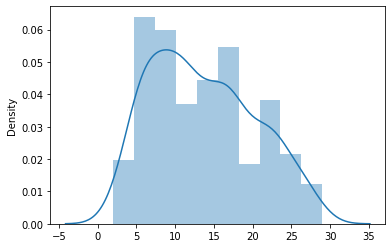

In [ ]:
visualization.visualize_tweet_length(train_data_df)
visualization.visualize_label_distribution(train_data_df)


# Train, save/serialize and evaluate the model


In [22]:
from importlib import reload  # Py3 only; unneeded in py2.
foo = reload(visualization)

[1]
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (TextV  (None, 50)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 50, 128)           9600128   
                                                                 
 LSTM_1 (LSTM)               (None, 50, 256)           394240    
                                                                 
 LSTM_2 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                       

INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/best_model.ckpt/assets


1250/1250 [==============================] - 127s 99ms/step - loss: 0.4534 - accuracy: 0.7784 - val_loss: 0.4035 - val_accuracy: 0.8161 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 109s 87ms/step - loss: 0.3823 - accuracy: 0.8284 - val_loss: 0.4069 - val_accuracy: 0.8183 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 109s 87ms/step - loss: 0.3541 - accuracy: 0.8432 - val_loss: 0.4190 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - 109s 87ms/step - loss: 0.3188 - accuracy: 0.8614 - val_loss: 0.4470 - val_accuracy: 0.8115 - lr: 0.0010
Epoch 5/20
1250/1250 [==============================] - 109s 87ms/step - loss: 0.2844 - accuracy: 0.8778 - val_loss: 0.5258 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 6/20
1250/1250 [==============================] - 109s 87ms/step - loss: 0.2581 - accuracy: 0.8900 - val_loss: 0.6130 - val_accuracy: 0.8018 - lr: 0.0010
Plotting the loss and accuracy graphs...


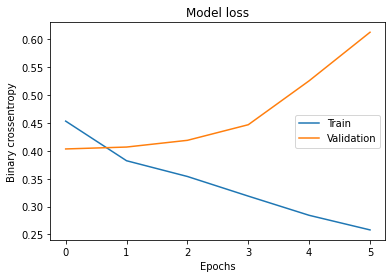

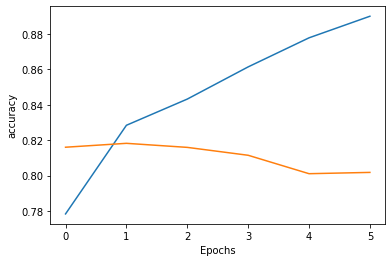

export_path = /content/mydrive/SentimentAnalysis/models/lstm_model



INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/lstm_model/assets


INFO:tensorflow:Assets written to: /content/mydrive/SentimentAnalysis/models/lstm_model/assets


2/2 [==============================] - 1s 18ms/step - loss: 0.8198 - accuracy: 0.7734


In [ ]:
model = LSTM.LSTM(config_main.CFG)
model.create_train_pipeline(train_data_df)
model.data_vectorization(config_main.CFG['model']['data_vectorization']['max_features'], 
                         config_main.CFG['model']['data_vectorization']['max_len'])

model.build_model()
model.train()

model.create_test_pipeline(test_data_df)
model.test()